In [15]:
pip install diffrax equinox optax jitcdde

In [16]:
import time

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
import symengine
from jitcdde import jitcdde, y, t
import numpy as np
import matplotlib.pyplot as plt

In [18]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.softplus,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.mlp(y)

class NeuralODE(eqx.Module):
    func: Func

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(data_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        #print(f"y0: {y0}")
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

$$
    \left\{\begin{array}{l}
    \frac{d T}{d t}=r T\left(1-\frac{T}{K}\right)-n E T,  \\
    \frac{d E}{d t}=\sigma+\mu T E-\eta E,
    \end{array}\right.
$$

In [19]:
def get_data(num_initial_points):
    r=2.5
    K=2.
    n=0.8
    omega=0.5
    miu=4.
    nu=1.5

    d = symengine.symbols("d")
    equations = [
        r * y(0, t) * (1 - (y(0, t) / K)) - n * y(1, t) * y(0, t),
        omega + miu * y(0, t - d) * y(1, t) - nu * y(1, t)
    ]
    ddesys = jitcdde(equations, control_pars=[d], max_delay=0.2)

    ts = np.linspace(0, 30, 1000)

    # Generar puntos iniciales aleatorios
    np.random.seed(67)
    initial_points = np.random.uniform(0, 2, size=(num_initial_points, 2))

    ys = []
    for initial_point in initial_points:
        ddesys.constant_past(initial_point)
        params = [0.2]
        ddesys.set_parameters(*params)
        y_values = []
        for t_val in ts:
            y_values.append(ddesys.integrate(t_val))
        ys.append(y_values)

    ys = np.array(ys)
    ts = jax.device_put(ts)
    ys = jax.device_put(ys)
    return ts, ys

In [20]:
def new_get_data(num_initial_points):
    r=2.5
    K=2.
    n=0.8
    omega=0.5
    miu=4.
    nu=1.5

    d = symengine.symbols("d")
    equations = [
        r * y(0, t) * (1 - (y(0, t) / K)) - n * y(1, t) * y(0, t),
        omega + miu * y(0, t - d) * y(1, t) - nu * y(1, t)
    ]
    ddesys = jitcdde(equations, control_pars=[d], max_delay=0.2)

    ts = np.linspace(0, 30, 1000)

    # Generar puntos iniciales aleatorios
    np.random.seed(83)
    initial_points = np.random.uniform(0, 2, size=(num_initial_points, 2))

    ys = []
    for initial_point in initial_points:
        ddesys.constant_past(initial_point)
        params = [0.2]
        ddesys.set_parameters(*params)
        y_values = []
        for t_val in ts:
            y_values.append(ddesys.integrate(t_val))
        ys.append(y_values)

    ys = np.array(ys)
    ts = jax.device_put(ts)
    ys = jax.device_put(ys)
    return ts, ys

In [23]:
def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

In [24]:
def main(
    dataset_size=500,
    batch_size=32,
    lr_strategy=(3e-3, 3e-3),
    steps_strategy=(1000, 1000),
    length_strategy=(0.1, 1),
    width_size=16,
    depth=4,
    seed=2,
    plot=True,
    print_every=100,
):
    key = jr.PRNGKey(seed)
    model_key, loader_key = jr.split(key, 2)
    ts, ys = get_data(dataset_size)
    _, length_size, data_size = ys.shape

    model = NeuralODE(data_size, width_size, depth, key=model_key)


    @eqx.filter_value_and_grad
    def grad_loss(model, ti, yi):
        #print(f"yi: {yi}")
        # yi es de tamaño: [32,10,2]
        # yi[:, 0] es en verdad la condición inicial de tamaño [32, 2]
        y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0, :])
        return jnp.mean((yi - y_pred) ** 2)

    # Es la clausura de la optimización
    # (i.e. lo que ocurre en cada paso)
    @eqx.filter_jit
    def make_step(ti, yi, model, opt_state):
        loss, grads = grad_loss(model, ti, yi)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    # Training loop like normal.
    #
    # Only thing to notice is that up until step 500 we train on only the first 10% of
    # each time series. This is a standard trick to avoid getting caught in a local
    # minimum.

    # Entrenar NeuralODEs es pesado. Es difícil.

    # lr_strategy: (3e-3, 3e-3)
    # steps_strategy: (500, 500)
    # length_strategy: (0.1, 1)

    # Este for loop es en verdad dos fases de entrenamiento:
    # En la primera fase, se entrena por 500 pasos en el 10% del conjunto de datos
    # En la segunda fase, se entrena por 500 pasos en todos los datos.
    for lr, steps, length in zip(lr_strategy, steps_strategy, length_strategy):
        optim = optax.adabelief(lr)
        opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
        _ts = ts[: int(length_size * length)]
        _ys = ys[:, : int(length_size * length)]
        for step, (yi,) in zip(
            range(steps), dataloader((_ys,), batch_size, key=loader_key)
        ):
            start = time.time()
            loss, model, opt_state = make_step(_ts, yi, model, opt_state)
            end = time.time()
            if (step % print_every) == 0 or step == steps - 1:
                print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

    if plot:

      index = 2
      new_size = int(dataset_size*0.1)
      ts_prueba, ys_prueba = new_get_data(new_size)

      model_y = model(ts_prueba, ys_prueba[index, 0])

      fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,6))
      fig.tight_layout(rect=[0, 0, 1, 0.95], pad=3.0)  # Ajustar diseño de la figura


      # Subgráfico 1
      ax1.plot(ts_prueba, ys_prueba[index, :, 0], c="dodgerblue", label="Real")
      ax1.plot(ts_prueba, model_y[:, 0], c="dodgerblue", label="Model", linestyle="dashed")
      ax1.set_xlabel('t')
      ax1.set_ylabel('T')
      ax1.legend()  # Añadir leyenda al subgráfico 1
      ax1.grid(True)  # Añadir rejilla al subgráfico 1

      # Subgráfico 2
      ax2.plot(ts_prueba, ys_prueba[index, :, 1], c="crimson", label="Real")
      ax2.plot(ts_prueba, model_y[:, 1], c="crimson", label="Model", linestyle="dashed")
      ax2.set_xlabel('t')
      ax2.set_ylabel('E')
      ax2.legend()  # Añadir leyenda al subgráfico 2
      ax2.grid(True)  # Añadir rejilla al subgráfico 2

      # Subgráfico 3
      ax3.plot(ys_prueba[index, :, 0], ys_prueba[index, :, 1], c="blue", label="Real")
      ax3.plot(model_y[:, 0], model_y[:, 1], c="red", label="Model", linestyle="dashed")
      ax3.set_xlabel('T')
      ax3.set_ylabel('E')
      ax3.legend()  # Añadir leyenda al subgráfico 3
      ax3.grid(True)  # Añadir rejilla al subgráfico 3

      # Mostrar la figura
      plt.show()

      errorT=((model_y[:, 0]-ys_prueba[0, :, 0])**2).mean()
      errorE=((model_y[:, 1]-ys_prueba[0, :, 1])**2).mean()
      return ts, ys, model
    else:
      new_size = int(dataset_size*0.3)
      ts_prueba, ys_prueba = new_get_data(new_size)
      model_y = jnp.zeros_like(ys_prueba)
      for i in range(ys_prueba.shape[0]):
        initial_value = ys_prueba[i, 0, :]
        model_y = model_y.at[i].set(model(ts_prueba, initial_value))
      diff_T = ys_prueba[:, :, 0] - model_y[:, :, 0]
      squared_diff_T = diff_T ** 2
      mse_T = jnp.mean(squared_diff_T)
      diff_E = ys_prueba[:, :, 1] - model_y[:, :, 1]
      squared_diff_E = diff_E ** 2
      mse_E = jnp.mean(squared_diff_E)
      error = jnp.mean(jnp.array([mse_E, mse_T]))
      print("El error cuadrático medio (MSE) es: para T", mse_T, ', para E',mse_E,'y general',error, 'depth:', depth, 'width_size:', width_size , 'seed:', seed)
      return ts, ys, model, error, depth, width_size



Generating, compiling, and loading C code.
Using default integration parameters.
Step: 0, Loss: 15.145848274230957, Computation time: 27.559316873550415
Step: 100, Loss: 3.258608818054199, Computation time: 0.008518457412719727
Step: 200, Loss: 0.6294534802436829, Computation time: 0.012721776962280273
Step: 300, Loss: 0.3471013307571411, Computation time: 0.01708221435546875
Step: 400, Loss: 0.18104268610477448, Computation time: 0.026867389678955078
Step: 500, Loss: 0.2154453992843628, Computation time: 0.014037132263183594
Step: 600, Loss: 0.15568946301937103, Computation time: 0.014194726943969727
Step: 700, Loss: 0.06570915877819061, Computation time: 0.02065253257751465
Step: 800, Loss: 0.11957502365112305, Computation time: 0.016233205795288086
Step: 900, Loss: 0.07510940730571747, Computation time: 0.013906478881835938
Step: 999, Loss: 0.06203996017575264, Computation time: 0.0164639949798584
Step: 0, Loss: 0.558914303779602, Computation time: 12.076546430587769
Step: 100, Loss

/usr/local/lib/python3.10/dist-packages/jitcdde/_jitcdde.py:795: UserWarning: You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.
  warn("You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.")
/usr/local/lib/python3.10/dist-packages/jitcdde/_jitcdde.py:792: UserWarning: The target time is smaller than the current time. 

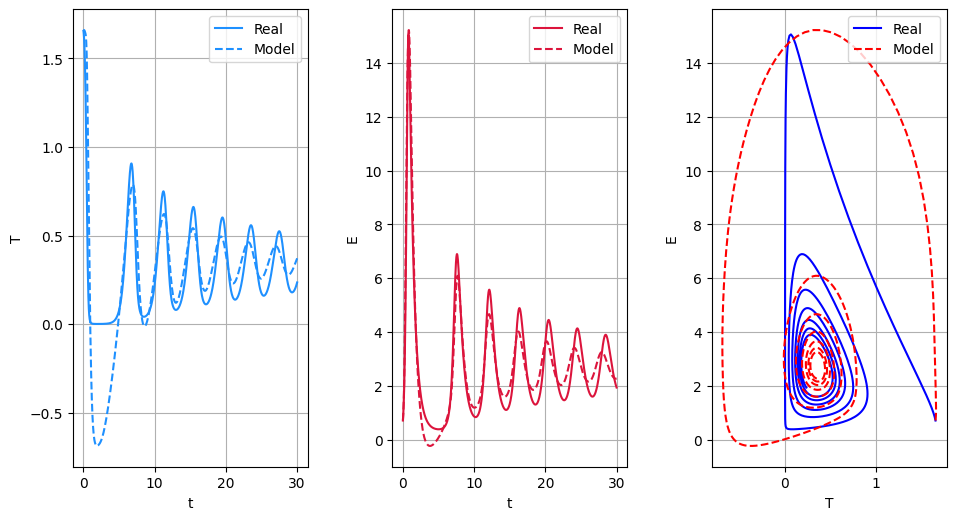

In [25]:
ts, ys, model = main()

Generating, compiling, and loading C code.
Using default integration parameters.


/usr/local/lib/python3.10/dist-packages/jitcdde/_jitcdde.py:795: UserWarning: You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.
  warn("You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.")
/usr/local/lib/python3.10/dist-packages/jitcdde/_jitcdde.py:792: UserWarning: The target time is smaller than the current time. 

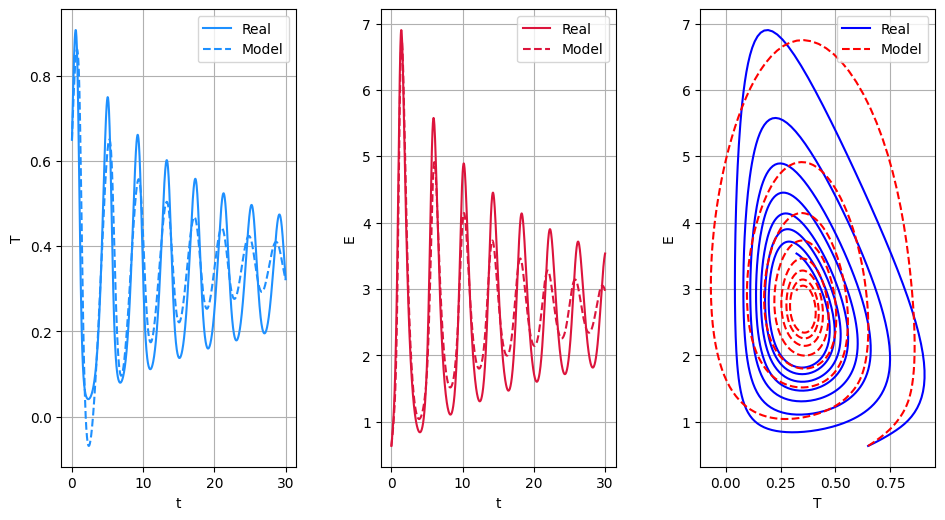

In [26]:
index = 15
new_size = int(256*0.1)
ts_prueba, ys_prueba = new_get_data(new_size)

model_y = model(ts_prueba, ys_prueba[index, 0])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,6))
fig.tight_layout(rect=[0, 0, 1, 0.95], pad=3.0)  # Ajustar diseño de la figura


# Subgráfico 1
ax1.plot(ts_prueba, ys_prueba[index, :, 0], c="dodgerblue", label="Real")
ax1.plot(ts_prueba, model_y[:, 0], c="dodgerblue", label="Model", linestyle="dashed")
ax1.set_xlabel('t')
ax1.set_ylabel('T')
ax1.legend()  # Añadir leyenda al subgráfico 1
ax1.grid(True)  # Añadir rejilla al subgráfico 1

# Subgráfico 2
ax2.plot(ts_prueba, ys_prueba[index, :, 1], c="crimson", label="Real")
ax2.plot(ts_prueba, model_y[:, 1], c="crimson", label="Model", linestyle="dashed")
ax2.set_xlabel('t')
ax2.set_ylabel('E')
ax2.legend()  # Añadir leyenda al subgráfico 2
ax2.grid(True)  # Añadir rejilla al subgráfico 2

# Subgráfico 3
ax3.plot(ys_prueba[index, :, 0], ys_prueba[index, :, 1], c="blue", label="Real")
ax3.plot(model_y[:, 0], model_y[:, 1], c="red", label="Model", linestyle="dashed")
ax3.set_xlabel('T')
ax3.set_ylabel('E')
ax3.legend()  # Añadir leyenda al subgráfico 3
ax3.grid(True)  # Añadir rejilla al subgráfico 3

# Mostrar la figura
plt.show()

errorT=((model_y[:, 0]-ys_prueba[0, :, 0])**2).mean()
errorE=((model_y[:, 1]-ys_prueba[0, :, 1])**2).mean()